#Mount Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe opencv-python numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing insta

#Feature Extraction and +labeling

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import scipy.io as sio

# === CONFIG ===
dataset_path = "/content/drive/MyDrive/AFLW2000"
output_csv = "/content/drive/MyDrive/combined_cervical_aflw.csv"

# === LABELING FUNCTION ===
def label_posture(pitch, yaw, roll, chin_tuck_ratio):
    if pitch > 12:
        if chin_tuck_ratio > 1.05:
            return "chin_tuck"
        return "flexion"
    elif pitch < -12:
        return "extension"
    elif abs(roll) > 10:
        return "lateral_tilt_right" if roll > 0 else "lateral_tilt_left"
    elif abs(yaw) > 15:
        return "rotation_right" if yaw > 0 else "rotation_left"
    else:
        return "neutral"

# === PARSE MAT FILES ===
mat_files = sorted(glob.glob(os.path.join(dataset_path, "*.mat")))
records = []

for mat_file in mat_files:
    try:
        mat = sio.loadmat(mat_file)

        # Extract pose angles and convert to degrees
        pitch, yaw, roll = mat['Pose_Para'][0][:3]
        pitch = np.degrees(float(pitch))
        yaw = np.degrees(float(yaw))
        roll = np.degrees(float(roll))

        # Get 3D landmarks
        landmarks_3d = mat['pt3d_68']  # shape: (3, 68)
        chin = landmarks_3d[:, 8]
        nose = landmarks_3d[:, 30]
        left_eye = landmarks_3d[:, 36]
        right_eye = landmarks_3d[:, 45]

        # Normalized chin tuck ratio
        eye_distance = np.linalg.norm(left_eye - right_eye)
        chin_tuck_ratio = eye_distance / (abs(nose[2] - chin[2]) + 1e-6)

        # Label
        label = label_posture(pitch, yaw, roll, chin_tuck_ratio)

        records.append({
            "pitch": pitch,
            "yaw": yaw,
            "roll": roll,
            "chin_tuck_ratio": chin_tuck_ratio,
            "label": label
        })
    except Exception as e:
        print(f"[ERROR] Failed to process {mat_file}: {e}")

# === SAVE CSV ===
df_aflw = pd.DataFrame(records)
df_aflw.to_csv(output_csv, index=False)

print(f"[INFO] Processed {len(df_aflw)} samples")
print(f"[INFO] Saved labeled dataset to {output_csv}")
print(df_aflw.head())
print(df_aflw["label"].value_counts())


[INFO] Processed 520 samples
[INFO] Saved labeled dataset to /content/drive/MyDrive/combined_cervical_aflw.csv
       pitch        yaw       roll  chin_tuck_ratio              label
0 -22.874239   1.044306   4.908886         1.087066          extension
1  26.932742  68.155241  17.243670         9.728591          chin_tuck
2 -10.579652  50.485412 -13.570645         4.275750  lateral_tilt_left
3 -10.048456  17.143374 -21.392783         2.106457  lateral_tilt_left
4 -50.544581  68.640546 -59.207973         7.190592          extension
label
extension             161
neutral               120
chin_tuck              63
lateral_tilt_left      51
lateral_tilt_right     46
rotation_right         41
rotation_left          38
Name: count, dtype: int64


#Data Visualization

/tmp/ipython-input-3727670597.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


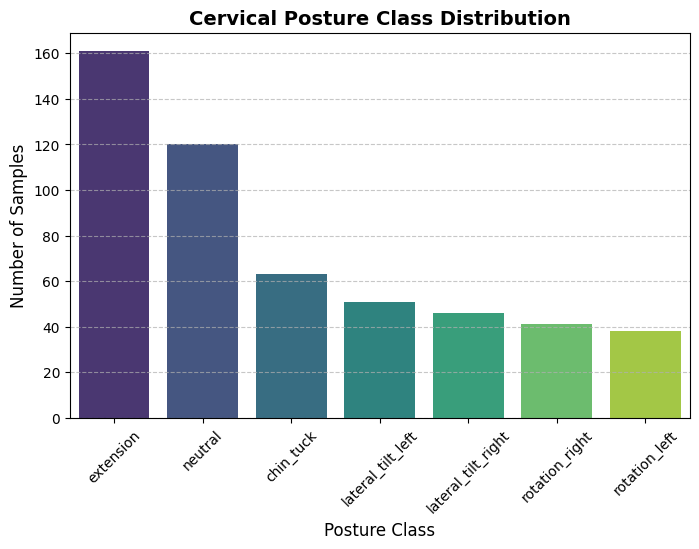

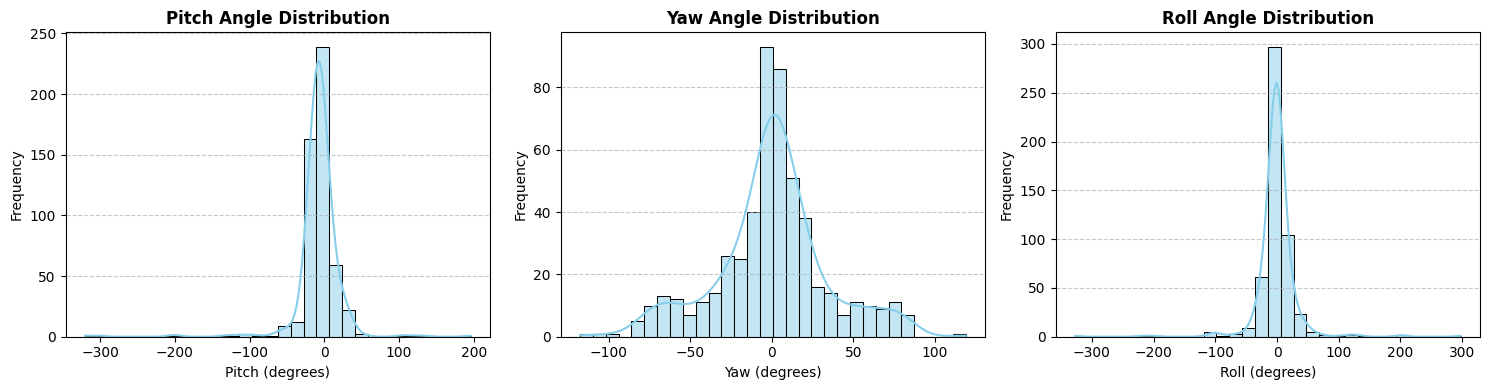

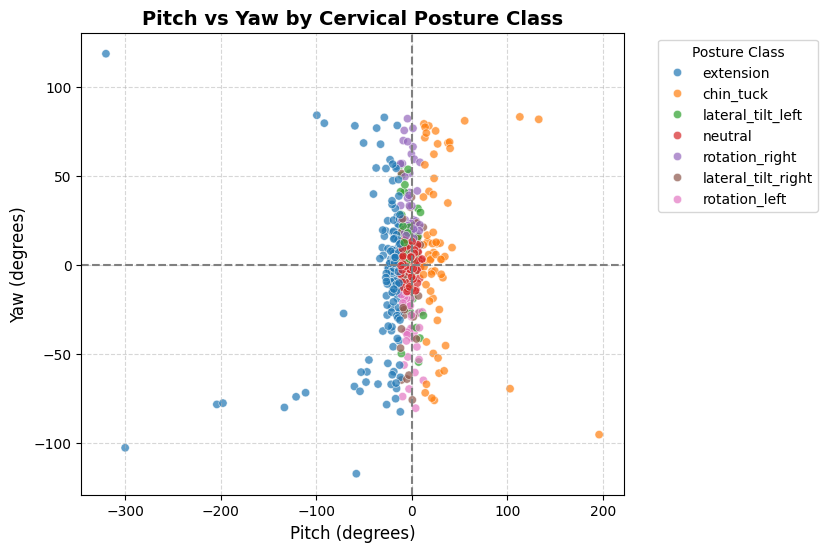

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load dataset ===
csv_path = "/content/drive/MyDrive/combined_cervical_aflw.csv"
df = pd.read_csv(csv_path)

# === 1. Class Distribution ===
plt.figure(figsize=(8,5))
sns.countplot(
    x="label",
    data=df,
    order=df["label"].value_counts().index,
    palette="viridis"
)
plt.title("Cervical Posture Class Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Posture Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# === 2. Pitch, Yaw, Roll Histograms ===
angles = ["pitch", "yaw", "roll"]
plt.figure(figsize=(15,4))
for i, col in enumerate(angles, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color="skyblue")
    plt.title(f"{col.capitalize()} Angle Distribution", fontsize=12, fontweight="bold")
    plt.xlabel(f"{col.capitalize()} (degrees)")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# === 3. Pitch vs Yaw Scatter Plot ===
plt.figure(figsize=(7,6))
sns.scatterplot(
    x="pitch", y="yaw",
    hue="label",
    data=df,
    palette="tab10",
    alpha=0.7
)
plt.title("Pitch vs Yaw by Cervical Posture Class", fontsize=14, fontweight="bold")
plt.xlabel("Pitch (degrees)", fontsize=12)
plt.ylabel("Yaw (degrees)", fontsize=12)
plt.axvline(0, color="gray", linestyle="--")
plt.axhline(0, color="gray", linestyle="--")
plt.legend(title="Posture Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


#Class balance throgh random oversampling +Model training +Evaluation

[INFO] Loaded 520 samples
[INFO] Class distribution before balancing:
Counter({'extension': 161, 'neutral': 120, 'chin_tuck': 63, 'lateral_tilt_left': 51, 'lateral_tilt_right': 46, 'rotation_right': 41, 'rotation_left': 38})


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



=== Classification Report ===
                    precision    recall  f1-score   support

         chin_tuck       1.00      0.92      0.96        13
         extension       1.00      1.00      1.00        32
 lateral_tilt_left       1.00      1.00      1.00        10
lateral_tilt_right       0.90      1.00      0.95         9
           neutral       0.89      1.00      0.94        24
     rotation_left       1.00      1.00      1.00         8
    rotation_right       1.00      0.62      0.77         8

          accuracy                           0.96       104
         macro avg       0.97      0.94      0.95       104
      weighted avg       0.97      0.96      0.96       104

Confusion Matrix:
[[12  0  0  1  0  0  0]
 [ 0 32  0  0  0  0  0]
 [ 0  0 10  0  0  0  0]
 [ 0  0  0  9  0  0  0]
 [ 0  0  0  0 24  0  0]
 [ 0  0  0  0  0  8  0]
 [ 0  0  0  0  3  0  5]]
Accuracy: 0.9615
[INFO] Model and artifacts saved to /content/drive/MyDrive/artifacts


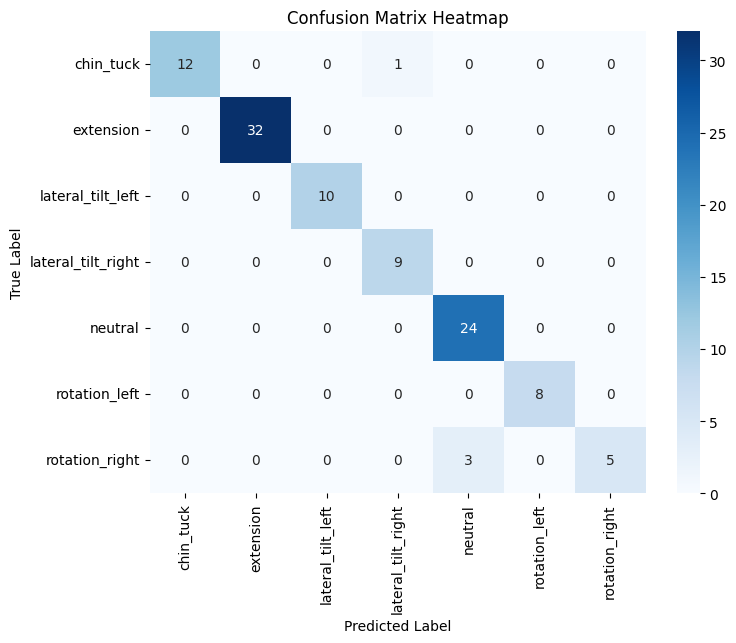

/tmp/ipython-input-2037548870.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


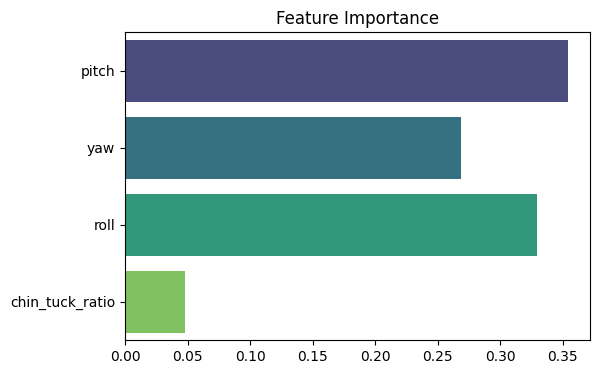

In [ ]:
# === Imports ===
import pandas as pd
import numpy as np
import os
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# === Config ===
input_csv = "/content/drive/MyDrive/combined_cervical_aflw.csv"
model_dir = "/content/drive/MyDrive/artifacts"
os.makedirs(model_dir, exist_ok=True)

# === 1. Load dataset ===
df = pd.read_csv(input_csv)
print(f"[INFO] Loaded {len(df)} samples")
print("[INFO] Class distribution before balancing:")
print(Counter(df["label"]))

# === 2. Split before balancing ===
X = df[["pitch", "yaw", "roll", "chin_tuck_ratio"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 3. Oversample only the training set ===
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# === Optional Augmentation (Gaussian noise) ===
def augment_with_noise(X, y, noise_level=0.05):
    """Add Gaussian noise to features for augmentation."""
    noisy_X = X + np.random.normal(0, noise_level, X.shape)
    return np.vstack((X, noisy_X)), np.hstack((y, y))

X_train_res, y_train_res = augment_with_noise(X_train_res.values, np.array(y_train_res), noise_level=0.05)

# === 4. Encode labels & scale ===
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_res)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# === 5. Train model ===
clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
clf.fit(X_train_scaled, y_train_enc)

# === 6. Evaluate ===
y_pred = clf.predict(X_test_scaled)
report = classification_report(y_test_enc, y_pred, target_names=le.classes_)
cm = confusion_matrix(y_test_enc, y_pred)
acc = accuracy_score(y_test_enc, y_pred)

print("\n=== Classification Report ===")
print(report)
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {acc:.4f}")

# === 7. Save artifacts ===
joblib.dump(clf, os.path.join(model_dir, "rf_posture.joblib"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.joblib"))
joblib.dump(le, os.path.join(model_dir, "label_encoder.joblib"))

# Save report
report_path = os.path.join(model_dir, "training_report.txt")
with open(report_path, "w") as f:
    f.write(report)
    f.write("\nConfusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write(f"\nAccuracy: {acc:.4f}\n")

print(f"[INFO] Model and artifacts saved to {model_dir}")

# === 8. Visualizations ===
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

importances = clf.feature_importances_
feature_names = ["pitch", "yaw", "roll", "chin_tuck_ratio"]
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importance")
plt.show()


#Gradio user interface

In [ ]:
!pip install pyngrok



In [ ]:
import os
import joblib
import numpy as np
import cv2
import gradio as gr
import mediapipe as mp

# === MediaPipe setup ===
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=1, min_detection_confidence=0.5, min_tracking_confidence=0.5
)

# === Load artifacts ===
ARTIFACT_DIR = "/content/drive/MyDrive/artifacts"
rf_clf = scaler = label_encoder = None
use_model = False
try:
    rf_clf = joblib.load(os.path.join(ARTIFACT_DIR, "rf_posture.joblib"))
    scaler = joblib.load(os.path.join(ARTIFACT_DIR, "scaler.joblib"))
    label_encoder = joblib.load(os.path.join(ARTIFACT_DIR, "label_encoder.joblib"))
    use_model = True
    print("[INFO] Loaded model artifacts.")
except Exception as e:
    print(f"[WARN] Could not load model artifacts, falling back to heuristic. {e}")

# === State & thresholds ===
rep_count = 0
last_state = "neutral"
neutral_vec = None
neutral_chin_dist = None

THRESHOLDS = {
    "flexion_deg": 12,
    "extension_deg": 12,
    "lateral_tilt_deg": 10,
    "rotation_deg": 15,
    "chin_tuck_ratio": 1.05
}

def unit(v):
    return v / (np.linalg.norm(v) + 1e-8)

def angle_between(v1, v2):
    v1_u, v2_u = unit(v1), unit(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def heuristic_label(metrics):
    pitch = metrics["flex_ext_angle"]
    yaw = metrics["yaw"]
    roll = metrics["roll_angle"]
    chin_tuck_ratio = metrics["chin_tuck_ratio"]
    if pitch > THRESHOLDS["flexion_deg"]:
        if chin_tuck_ratio > THRESHOLDS["chin_tuck_ratio"]:
            return "chin_tuck"
        return "flexion"
    if pitch < -THRESHOLDS["extension_deg"]:
        return "extension"
    if abs(roll) > THRESHOLDS["lateral_tilt_deg"]:
        return "lateral_tilt_right" if roll > 0 else "lateral_tilt_left"
    if abs(yaw) > THRESHOLDS["rotation_deg"]:
        return "rotation_right" if yaw > 0 else "rotation_left"
    return "neutral"

def compute_metrics(pose_landmarks, img_shape, neutral_vec_ref, neutral_chin_dist_ref):
    h, w = img_shape[:2]
    def lm(idx):
        l = pose_landmarks.landmark[idx]
        return np.array([l.x * w, l.y * h])
    left_sh = lm(mp_holistic.PoseLandmark.LEFT_SHOULDER)
    right_sh = lm(mp_holistic.PoseLandmark.RIGHT_SHOULDER)
    shoulder_mid = (left_sh + right_sh) / 2.0
    nose = lm(mp_holistic.PoseLandmark.NOSE)
    neck_vec = nose - shoulder_mid

    flex_ext_angle = angle_between(neck_vec, neutral_vec_ref)
    roll = np.degrees(np.arctan2(neck_vec[0], -neck_vec[1]))
    left_eye = lm(mp_holistic.PoseLandmark.LEFT_EYE)
    right_eye = lm(mp_holistic.PoseLandmark.RIGHT_EYE)
    eye_mid = (left_eye + right_eye) / 2.0
    yaw_offset = nose[0] - eye_mid[0]
    yaw = np.degrees(np.arctan2(yaw_offset, w)) * 180
    curr_chin_dist = np.linalg.norm(nose - shoulder_mid)
    chin_tuck_ratio = neutral_chin_dist_ref / (curr_chin_dist + 1e-8)

    return {
        "flex_ext_angle": flex_ext_angle,
        "roll_angle": roll,
        "yaw": yaw,
        "chin_tuck_ratio": chin_tuck_ratio,
        "neck_vec": neck_vec
    }

def inference_image(frame, selected_target):
    global last_state, rep_count, neutral_vec, neutral_chin_dist
    target_label = selected_target

    feedback = "No pose detected"
    label = "neutral"
    confidence = 0.0

    if frame is None:
        return None, "No input"

    # Gradio gives RGB
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    results = holistic.process(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))

    if neutral_vec is None and results.pose_landmarks:
        tmp = compute_metrics(results.pose_landmarks, frame_bgr.shape, np.array([0.0, -1.0]), 1.0)
        neutral_vec = tmp["neck_vec"]
        neutral_chin_dist = 1.0

    if results.pose_landmarks:
        metrics = compute_metrics(results.pose_landmarks, frame_bgr.shape, neutral_vec, neutral_chin_dist)

        if use_model and rf_clf is not None:
            feat = np.array([
                metrics["flex_ext_angle"],
                metrics["roll_angle"],
                metrics["yaw"],
                metrics["chin_tuck_ratio"]
            ], dtype=np.float32).reshape(1, -1)
            feat_scaled = scaler.transform(feat)
            pred_idx = rf_clf.predict(feat_scaled)[0]
            label = label_encoder.inverse_transform([pred_idx])[0]
            if hasattr(rf_clf, "predict_proba"):
                probs = rf_clf.predict_proba(feat_scaled)[0]
                confidence = float(np.max(probs))
        else:
            label = heuristic_label(metrics)
            confidence = 1.0

        if label == target_label:
            if last_state != target_label:
                rep_count += 1
            feedback = f"✅ Correct ({label})  Reps: {rep_count}"
        else:
            feedback = f"❌ Incorrect. Target: {target_label}, You are: {label}"

        last_state = label

        color = (0, 255, 0) if label == target_label else (0, 0, 255)
        cv2.putText(frame_bgr, f"Target: {target_label}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (200, 200, 0), 2)
        cv2.putText(frame_bgr, f"Your: {label}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
        cv2.putText(frame_bgr, f"Reps: {rep_count}", (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
        cv2.putText(frame_bgr, f"Conf: {confidence:.2f}", (10, 120),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    annotated = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    return annotated, feedback

def reset_state():
    global rep_count, last_state, neutral_vec, neutral_chin_dist
    rep_count = 0
    last_state = "neutral"
    neutral_vec = None
    neutral_chin_dist = None
    return "Reset done."

# === Gradio interface ===
with gr.Blocks() as demo:
    gr.Markdown("## Cervical Posture Trainer")
    with gr.Row():
        image_input = gr.Image(type="numpy", label="Upload Frame or Snapshot")
        output_img = gr.Image(label="Annotated Output")
    with gr.Row():
        target_dropdown = gr.Dropdown(
            choices=[
                "flexion", "extension",
                "lateral_tilt_left", "lateral_tilt_right",
                "rotation_left", "rotation_right",
                "chin_tuck"
            ],
            value="flexion",
            label="Target Posture"
        )
        run_btn = gr.Button("Run Inference")
        reset_btn = gr.Button("Reset")
    feedback_box = gr.Textbox(label="Feedback", interactive=False)

    run_btn.click(fn=inference_image, inputs=[image_input, target_dropdown], outputs=[output_img, feedback_box])
    reset_btn.click(fn=reset_state, inputs=None, outputs=feedback_box)

    gr.Markdown("### Notes: uses trained model if available; otherwise heuristic fallback.")

if __name__ == "__main__":
    demo.launch()


[INFO] Loaded model artifacts.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://23b8c21c17ce27e780.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from pyngrok import ngrok
import threading

def start_ngrok(port):
    ngrok.set_auth_token("30m9gN1gpiXVNFClX50QaiRG3E5_4B9gmrDTQoN1VaciiWrKi")  # replace with your actual token
    tunnel = ngrok.connect(port, bind_tls=True)
    print(f"ngrok public URL: {tunnel.public_url}")
    return tunnel

if __name__ == "__main__":
    # Launch ngrok tunnel in background
    port = 7860
    tunnel = start_ngrok(port)

    # Launch Gradio app accessible on all interfaces so ngrok can reach it
    demo.launch(server_name="0.0.0.0", server_port=port, share=False)


In [ ]:
import os
from pyngrok import ngrok, conf, exception
import getpass

# === Config ===
PORT = int(os.environ.get("PORT", 7860))
ARTIFACT_DIR = os.environ.get("ARTIFACT_DIR", "/content/drive/MyDrive/artifacts")

# === Ngrok auth resolution ===
token = os.environ.get("NGROK_AUTH_TOKEN")
if not token:
    # Prompt securely (hides input) if running interactively (e.g., Colab or shell)
    try:
        token = getpass.getpass("Enter your ngrok authtoken (will not echo): ").strip()
    except Exception:
        token = None

if not token:
    raise RuntimeError(
        "[ERROR] Ngrok authtoken not provided. Either set the environment variable "
        "`NGROK_AUTH_TOKEN` or input it when prompted."
    )

# Apply token
conf.get_default().auth_token = token

# Establish tunnel
try:
    tunnel = ngrok.connect(PORT, "http")  # add options={"auth":"user:pass"} if you want basic auth
    public_url = tunnel.public_url
    print(f"[ngrok] Tunnel established: {public_url} -> http://localhost:{PORT}")
except exception.PyngrokNgrokError as e:
    print(f"[ERROR] ngrok failed to start: {e}")
    print(f"Tip: you can manually run `./ngrok authtoken <your_token>` and then `./ngrok http {PORT}`.")
    raise


Enter your ngrok authtoken (will not echo): ··········
[ngrok] Tunnel established: https://6af2d3f614f7.ngrok-free.app -> http://localhost:7860


In [ ]:
export NGROK_AUTH_TOKEN="30m9gN1gpiXVNFClX50QaiRG3E5_4B9gmrDTQoN1VaciiWrKi"
export ARTIFACT_DIR="/content/drive/MyDrive/artifacts"  # adjust if needed
export PORT=7860
python app_with_ngrok.py


SyntaxError: invalid syntax (ipython-input-204617075.py, line 1)